# Import & Setup

##### Target Libraries

In [1]:
# Setup:
import eli5
import numpy as np
import pandas as pd
import streamlit as st

# Plot:
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning:
from catboost import CatBoostClassifier
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

# Interpretation:
from eli5 import show_weights
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_plot, pdp_interact_plot
from sklearn.inspection import permutation_importance
import shap

In [2]:
# This code enables intellisense.
%config IPCompleter.greedy=True

In [3]:
# To display all columns and more rows.
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

# This code is to ignore copy warnings.
pd.options.mode.chained_assignment = None

In [4]:
# This will set the style for all
# bar plots:
plt.style.use('fivethirtyeight')

##### Other Libraries

In [5]:
# For libraries needed not in target library section
import joblib
from datetime import datetime
from pandas_profiling import ProfileReport

##### Testing

In [6]:
# Just testing how to load a pickle file
model_pkl = pd.read_pickle(r'randomforest_modelv1.pkl')
model_pkl

array(['Emergency Shelter', 'Permanent Exit', 'Temporary Exit',
       'Transitional Housing', 'Unknown/Other'], dtype=object)

In [7]:
# Just testing how to load a joblib file
model_job = joblib.load('randomforest_model.joblib')
model_pkl

array(['Emergency Shelter', 'Permanent Exit', 'Temporary Exit',
       'Transitional Housing', 'Unknown/Other'], dtype=object)

# EDA

In [52]:
# Using the cleanest dataset from data exploration notebook
df = pd.read_csv('All_data_with_exits_cleaned.csv')

In [53]:
%%capture

# This create a pandas profile report and saves
# a html link in current directory.
profile = ProfileReport(df, minimal=True)
profile.to_file("Pandas Profile.html")

In [54]:
print("df shape:", df.shape)
df.head(5)

df shape: (1862, 70)


,Project Name,Relationship to HoH,CaseMembers,Enroll Date,Exit Date,Social Security Quality,Age at Enrollment,Race,Ethnicity,Gender,Veteran Status,Disabling Condition at Entry,Living Situation,Length of Stay,Homeless Start Date,Length of Time Homeless (Approximate Start),Times Homeless Last Years,Total Months Homeless Last Years,Last Permanent Address,State,Zip,Days Enrolled in Project,Housing Status,Covered by Health Insurance,Domestic Violence,Current Status (Retired Data Element),Connected to McKinney Vento Liason (Retired),Household Type,Last Grade Completed,School Status,Employed Status,Why Not Employed,Count of Bed Nights (Housing Check-ins),Date of Last ES Stay (Beta),Date of First ES Stay (Beta),Income Total at Entry,Income Total at Exit,Non-Cash Benefit Count,Non-Cash Benefit Count at Exit,Barrier Count at Entry,Under Years Old,Chronic Health Condition,Mental Health Problem,CaseChildren,CaseAdults,Other Public,State Funded,Indian Health Services (IHS),Other,Combined Childrens HealthInsurance/Medicaid,Medicaid,Medicare,State Children's health Insurance S-CHIP,Veteran's Administration Medical Services,Health Insurance obtained through COBRA,Private - Employer,Private,Private - Individual,Earned Income,Unemployment Insurance,Supplemental Security Income,Social Security Disability Income,VA Disability Compensation,Private Disability Income,Workers Compensation,TANF,General Assistance,Child Support,Other Income,Target Exit Destination
0,FPS--ES--Bridges Family Shelter,Son,6,736582,736702,Client Refused,4,White,Non-Hispanic/Latino,Male,NaN,No,NaN,Unknown,1,NaN,NaN,NaN,NaN,NaN,NaN,120,NaN,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,NaN,NaN,0,0,0,Yes,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,0.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
1,FPS--ES--Bridges Family Shelter,Self,6,736582,736702,Full SSN,28,White,Non-Hispanic/Latino,Male,No,Missing,Hotel or motel paid for without emergency shel...,"One month or more, but less than 90 days",735538,1164.0,Three times,More than 12 months,Data not collected,NaN,NaN,120,Category 1 - Homeless,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,1300.0,NaN,0,0,1,No,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,1300.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
2,FPS--ES--Bridges Family Shelter,Daughter,6,736582,736718,Client Refused,10,White,Non-Hispanic/Latino,Female,NaN,No,NaN,Unknown,1,NaN,NaN,NaN,NaN,NaN,NaN,136,NaN,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,NaN,NaN,0,0,0,Yes,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,0.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
3,FPS--ES--Bridges Family Shelter,Son,6,736582,736702,Full SSN,5,White,Non-Hispanic/Latino,Male,NaN,No,NaN,Unknown,1,NaN,NaN,NaN,NaN,NaN,NaN,120,Category 1 - Homeless,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,NaN,NaN,0,0,0,Yes,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,0.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
4,FPS--ES--Bridges Family Shelter,Significant Other (Non-Married),6,736582,736702,Client Refused,27,White,Non-Hispanic/Latino,Female,No,Yes,Hotel or motel paid for without emergency shel...,Unknown,736212,490.0,NaN,More than 12 months,NaN,NaN,NaN,120,Category 1 - Homeless,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,1200.0,1600.0,1,0,2,No,NaN,Mental Illness,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,1200.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other


# Wrangling

In [55]:
# Dropping the [other] column
# It shows no meaning
df = df.drop('Other', axis=1)

In [42]:
# Need ordinal dates to train models
# Useless code below for model interpretation:

# # Changing the ordinal dates into real world
# # datetime dates
# for i, dt in enumerate(df['Enroll Date']):
#     df['Enroll Date'][i] = datetime.fromordinal(dt)
    
# for i, dt in enumerate(df['Exit Date']):
#     if dt == 1:
#         continue
#     df['Exit Date'][i] = datetime.fromordinal(dt)
    
# for i, dt in enumerate(df['Homeless Start Date']):
#     if dt == 1:
#         continue
#     df['Homeless Start Date'][i] = datetime.fromordinal(dt)
    
# for i, dt in enumerate(df['Date of Last ES Stay (Beta)']):
#     if dt == 1:
#         continue
#     df['Date of Last ES Stay (Beta)'][i] = datetime.fromordinal(dt)
    
# for i, dt in enumerate(df['Date of First ES Stay (Beta)']):
#     if dt == 1:
#         continue
#     df['Date of First ES Stay (Beta)'][i] = datetime.fromordinal(dt)

# # Replacing exit dates value of 1 to NaN
# df['Exit Date'] = df['Exit Date'].replace(1, np.nan)
# df['Homeless Start Date'] = df['Homeless Start Date'].replace(1, np.nan)
# df['Date of Last ES Stay (Beta)'] = df['Date of Last ES Stay (Beta)'].replace(1, np.nan)
# df['Date of First ES Stay (Beta)'] = df['Date of First ES Stay (Beta)'].replace(1, np.nan)

# # Changing the date columns in datetime format
# df['Enroll Date'] = pd.to_datetime(df['Enroll Date'])
# df['Exit Date'] = pd.to_datetime(df['Exit Date'])
# df['Homeless Start Date'] = pd.to_datetime(df['Homeless Start Date'])
# df['Date of Last ES Stay (Beta)'] = pd.to_datetime(df['Date of Last ES Stay (Beta)'])
# df['Date of First ES Stay (Beta)'] = pd.to_datetime(df['Date of First ES Stay (Beta)'])

##### Saving csv

In [56]:
df.to_csv("../visuals/All_data_with_exits_cleaned_v2.csv", index=False)

# Split Data

In [57]:
target = 'Target Exit Destination'
X = df.drop(target, axis=1)
y = df[target]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80,
                                                    test_size=0.20, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75,
                                                  test_size=0.25, random_state=0)

# Sets Information

In [59]:
print("Training: 80%")
print("Validation: 20%")
print("Test: 20%")
print("")
print("Training set shape: ", X_train.shape)
print("Validation set shape: ", X_val.shape)
print("Test set shape: ", X_test.shape)

Training: 80%
Validation: 20%
Test: 20%

Training set shape:  (1116, 68)
Validation set shape:  (373, 68)
Test set shape:  (373, 68)


# Baseline

In [60]:
y.value_counts(normalize=True)

Unknown/Other           0.353921
Permanent Exit          0.317938
Emergency Shelter       0.209989
Temporary Exit          0.066058
Transitional Housing    0.052095
Name: Target Exit Destination, dtype: float64

# Models
- Encoded with `OrdinalEncoder`

## `CatBoostClassifier`

In [61]:
cat_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    CatBoostClassifier(iterations=5000, random_state=0)
)

cat_model.fit(X_train, y_train)

Learning rate set to 0.020423
0:	learn: 1.5998057	total: 53.2ms	remaining: 4m 26s
1:	learn: 1.5890332	total: 56.5ms	remaining: 2m 21s
2:	learn: 1.5816302	total: 59.9ms	remaining: 1m 39s
3:	learn: 1.5714659	total: 63.2ms	remaining: 1m 18s
4:	learn: 1.5609628	total: 66.3ms	remaining: 1m 6s
5:	learn: 1.5513015	total: 69.8ms	remaining: 58.1s
6:	learn: 1.5421370	total: 72.8ms	remaining: 51.9s
7:	learn: 1.5316794	total: 76.5ms	remaining: 47.8s
8:	learn: 1.5237737	total: 80.8ms	remaining: 44.8s
9:	learn: 1.5163300	total: 84.1ms	remaining: 42s
10:	learn: 1.5100552	total: 87.8ms	remaining: 39.8s
11:	learn: 1.5029124	total: 90.9ms	remaining: 37.8s
12:	learn: 1.4957559	total: 95ms	remaining: 36.4s
13:	learn: 1.4869410	total: 97.9ms	remaining: 34.9s
14:	learn: 1.4781698	total: 101ms	remaining: 33.6s
15:	learn: 1.4706507	total: 105ms	remaining: 32.6s
16:	learn: 1.4650405	total: 108ms	remaining: 31.6s
17:	learn: 1.4575896	total: 111ms	remaining: 30.8s
18:	learn: 1.4520071	total: 113ms	remaining: 29.

189:	learn: 1.0772238	total: 695ms	remaining: 17.6s
190:	learn: 1.0755098	total: 698ms	remaining: 17.6s
191:	learn: 1.0743860	total: 702ms	remaining: 17.6s
192:	learn: 1.0726645	total: 706ms	remaining: 17.6s
193:	learn: 1.0719486	total: 710ms	remaining: 17.6s
194:	learn: 1.0704517	total: 714ms	remaining: 17.6s
195:	learn: 1.0691393	total: 718ms	remaining: 17.6s
196:	learn: 1.0681190	total: 721ms	remaining: 17.6s
197:	learn: 1.0675885	total: 724ms	remaining: 17.6s
198:	learn: 1.0663246	total: 727ms	remaining: 17.5s
199:	learn: 1.0656866	total: 730ms	remaining: 17.5s
200:	learn: 1.0648178	total: 733ms	remaining: 17.5s
201:	learn: 1.0638889	total: 736ms	remaining: 17.5s
202:	learn: 1.0634505	total: 740ms	remaining: 17.5s
203:	learn: 1.0615355	total: 743ms	remaining: 17.5s
204:	learn: 1.0605628	total: 747ms	remaining: 17.5s
205:	learn: 1.0596714	total: 750ms	remaining: 17.4s
206:	learn: 1.0587161	total: 753ms	remaining: 17.4s
207:	learn: 1.0570842	total: 756ms	remaining: 17.4s
208:	learn: 

391:	learn: 0.8861508	total: 1.39s	remaining: 16.3s
392:	learn: 0.8855084	total: 1.39s	remaining: 16.3s
393:	learn: 0.8848174	total: 1.39s	remaining: 16.3s
394:	learn: 0.8839211	total: 1.4s	remaining: 16.3s
395:	learn: 0.8830713	total: 1.4s	remaining: 16.3s
396:	learn: 0.8824085	total: 1.41s	remaining: 16.3s
397:	learn: 0.8813549	total: 1.41s	remaining: 16.3s
398:	learn: 0.8801078	total: 1.41s	remaining: 16.3s
399:	learn: 0.8792170	total: 1.42s	remaining: 16.3s
400:	learn: 0.8783899	total: 1.42s	remaining: 16.3s
401:	learn: 0.8778106	total: 1.42s	remaining: 16.3s
402:	learn: 0.8763934	total: 1.43s	remaining: 16.3s
403:	learn: 0.8756837	total: 1.43s	remaining: 16.3s
404:	learn: 0.8745265	total: 1.44s	remaining: 16.3s
405:	learn: 0.8735162	total: 1.44s	remaining: 16.3s
406:	learn: 0.8725519	total: 1.44s	remaining: 16.3s
407:	learn: 0.8718757	total: 1.45s	remaining: 16.3s
408:	learn: 0.8709129	total: 1.45s	remaining: 16.3s
409:	learn: 0.8695180	total: 1.45s	remaining: 16.3s
410:	learn: 0.

594:	learn: 0.7289511	total: 2.08s	remaining: 15.4s
595:	learn: 0.7285830	total: 2.08s	remaining: 15.4s
596:	learn: 0.7282311	total: 2.09s	remaining: 15.4s
597:	learn: 0.7275791	total: 2.09s	remaining: 15.4s
598:	learn: 0.7270166	total: 2.1s	remaining: 15.4s
599:	learn: 0.7266049	total: 2.1s	remaining: 15.4s
600:	learn: 0.7260450	total: 2.1s	remaining: 15.4s
601:	learn: 0.7256231	total: 2.1s	remaining: 15.4s
602:	learn: 0.7245181	total: 2.11s	remaining: 15.4s
603:	learn: 0.7236094	total: 2.11s	remaining: 15.4s
604:	learn: 0.7226735	total: 2.12s	remaining: 15.4s
605:	learn: 0.7215813	total: 2.12s	remaining: 15.4s
606:	learn: 0.7210442	total: 2.12s	remaining: 15.4s
607:	learn: 0.7207138	total: 2.13s	remaining: 15.4s
608:	learn: 0.7203195	total: 2.13s	remaining: 15.4s
609:	learn: 0.7199009	total: 2.13s	remaining: 15.4s
610:	learn: 0.7194887	total: 2.14s	remaining: 15.4s
611:	learn: 0.7190146	total: 2.14s	remaining: 15.4s
612:	learn: 0.7182410	total: 2.15s	remaining: 15.4s
613:	learn: 0.71

798:	learn: 0.6201713	total: 2.77s	remaining: 14.6s
799:	learn: 0.6200324	total: 2.78s	remaining: 14.6s
800:	learn: 0.6195594	total: 2.79s	remaining: 14.6s
801:	learn: 0.6190710	total: 2.79s	remaining: 14.6s
802:	learn: 0.6186225	total: 2.79s	remaining: 14.6s
803:	learn: 0.6180678	total: 2.79s	remaining: 14.6s
804:	learn: 0.6174930	total: 2.8s	remaining: 14.6s
805:	learn: 0.6171561	total: 2.8s	remaining: 14.6s
806:	learn: 0.6166643	total: 2.81s	remaining: 14.6s
807:	learn: 0.6161792	total: 2.81s	remaining: 14.6s
808:	learn: 0.6157397	total: 2.81s	remaining: 14.6s
809:	learn: 0.6152513	total: 2.81s	remaining: 14.6s
810:	learn: 0.6145791	total: 2.82s	remaining: 14.6s
811:	learn: 0.6135406	total: 2.82s	remaining: 14.6s
812:	learn: 0.6131312	total: 2.83s	remaining: 14.6s
813:	learn: 0.6127089	total: 2.83s	remaining: 14.5s
814:	learn: 0.6120294	total: 2.83s	remaining: 14.5s
815:	learn: 0.6115657	total: 2.83s	remaining: 14.5s
816:	learn: 0.6109301	total: 2.84s	remaining: 14.5s
817:	learn: 0.

998:	learn: 0.5321790	total: 3.47s	remaining: 13.9s
999:	learn: 0.5317370	total: 3.47s	remaining: 13.9s
1000:	learn: 0.5314102	total: 3.48s	remaining: 13.9s
1001:	learn: 0.5310707	total: 3.48s	remaining: 13.9s
1002:	learn: 0.5308211	total: 3.48s	remaining: 13.9s
1003:	learn: 0.5304918	total: 3.48s	remaining: 13.9s
1004:	learn: 0.5303371	total: 3.49s	remaining: 13.9s
1005:	learn: 0.5301568	total: 3.49s	remaining: 13.9s
1006:	learn: 0.5297833	total: 3.5s	remaining: 13.9s
1007:	learn: 0.5293358	total: 3.5s	remaining: 13.9s
1008:	learn: 0.5289347	total: 3.5s	remaining: 13.9s
1009:	learn: 0.5288080	total: 3.5s	remaining: 13.8s
1010:	learn: 0.5285826	total: 3.51s	remaining: 13.8s
1011:	learn: 0.5280827	total: 3.51s	remaining: 13.8s
1012:	learn: 0.5279014	total: 3.51s	remaining: 13.8s
1013:	learn: 0.5273218	total: 3.52s	remaining: 13.8s
1014:	learn: 0.5269863	total: 3.52s	remaining: 13.8s
1015:	learn: 0.5265072	total: 3.53s	remaining: 13.8s
1016:	learn: 0.5262358	total: 3.53s	remaining: 13.8s

1200:	learn: 0.4690163	total: 4.16s	remaining: 13.2s
1201:	learn: 0.4687524	total: 4.16s	remaining: 13.2s
1202:	learn: 0.4682818	total: 4.17s	remaining: 13.1s
1203:	learn: 0.4680252	total: 4.17s	remaining: 13.2s
1204:	learn: 0.4677265	total: 4.17s	remaining: 13.2s
1205:	learn: 0.4674398	total: 4.18s	remaining: 13.1s
1206:	learn: 0.4670161	total: 4.18s	remaining: 13.1s
1207:	learn: 0.4667111	total: 4.18s	remaining: 13.1s
1208:	learn: 0.4662761	total: 4.19s	remaining: 13.1s
1209:	learn: 0.4660078	total: 4.19s	remaining: 13.1s
1210:	learn: 0.4657938	total: 4.2s	remaining: 13.1s
1211:	learn: 0.4654412	total: 4.2s	remaining: 13.1s
1212:	learn: 0.4652036	total: 4.21s	remaining: 13.1s
1213:	learn: 0.4648547	total: 4.21s	remaining: 13.1s
1214:	learn: 0.4644709	total: 4.21s	remaining: 13.1s
1215:	learn: 0.4643534	total: 4.22s	remaining: 13.1s
1216:	learn: 0.4639996	total: 4.22s	remaining: 13.1s
1217:	learn: 0.4638309	total: 4.23s	remaining: 13.1s
1218:	learn: 0.4636003	total: 4.23s	remaining: 1

1402:	learn: 0.4165442	total: 4.85s	remaining: 12.4s
1403:	learn: 0.4164002	total: 4.86s	remaining: 12.4s
1404:	learn: 0.4160768	total: 4.86s	remaining: 12.4s
1405:	learn: 0.4159736	total: 4.87s	remaining: 12.4s
1406:	learn: 0.4157864	total: 4.87s	remaining: 12.4s
1407:	learn: 0.4152998	total: 4.87s	remaining: 12.4s
1408:	learn: 0.4148963	total: 4.88s	remaining: 12.4s
1409:	learn: 0.4145630	total: 4.88s	remaining: 12.4s
1410:	learn: 0.4141532	total: 4.88s	remaining: 12.4s
1411:	learn: 0.4138856	total: 4.89s	remaining: 12.4s
1412:	learn: 0.4136733	total: 4.89s	remaining: 12.4s
1413:	learn: 0.4134336	total: 4.89s	remaining: 12.4s
1414:	learn: 0.4132061	total: 4.9s	remaining: 12.4s
1415:	learn: 0.4130025	total: 4.9s	remaining: 12.4s
1416:	learn: 0.4125347	total: 4.9s	remaining: 12.4s
1417:	learn: 0.4123839	total: 4.91s	remaining: 12.4s
1418:	learn: 0.4123252	total: 4.91s	remaining: 12.4s
1419:	learn: 0.4120589	total: 4.91s	remaining: 12.4s
1420:	learn: 0.4119401	total: 4.92s	remaining: 12

1558:	learn: 0.3787148	total: 5.38s	remaining: 11.9s
1559:	learn: 0.3784996	total: 5.38s	remaining: 11.9s
1560:	learn: 0.3781432	total: 5.38s	remaining: 11.9s
1561:	learn: 0.3779587	total: 5.39s	remaining: 11.9s
1562:	learn: 0.3776502	total: 5.39s	remaining: 11.9s
1563:	learn: 0.3774967	total: 5.39s	remaining: 11.8s
1564:	learn: 0.3773041	total: 5.4s	remaining: 11.8s
1565:	learn: 0.3771485	total: 5.4s	remaining: 11.8s
1566:	learn: 0.3768046	total: 5.4s	remaining: 11.8s
1567:	learn: 0.3765258	total: 5.41s	remaining: 11.8s
1568:	learn: 0.3762335	total: 5.41s	remaining: 11.8s
1569:	learn: 0.3760997	total: 5.41s	remaining: 11.8s
1570:	learn: 0.3759242	total: 5.42s	remaining: 11.8s
1571:	learn: 0.3756833	total: 5.42s	remaining: 11.8s
1572:	learn: 0.3754276	total: 5.42s	remaining: 11.8s
1573:	learn: 0.3753359	total: 5.43s	remaining: 11.8s
1574:	learn: 0.3750543	total: 5.43s	remaining: 11.8s
1575:	learn: 0.3747312	total: 5.43s	remaining: 11.8s
1576:	learn: 0.3746019	total: 5.44s	remaining: 11

1763:	learn: 0.3393477	total: 6.07s	remaining: 11.1s
1764:	learn: 0.3392281	total: 6.07s	remaining: 11.1s
1765:	learn: 0.3390619	total: 6.08s	remaining: 11.1s
1766:	learn: 0.3389314	total: 6.08s	remaining: 11.1s
1767:	learn: 0.3387014	total: 6.08s	remaining: 11.1s
1768:	learn: 0.3384549	total: 6.09s	remaining: 11.1s
1769:	learn: 0.3382600	total: 6.09s	remaining: 11.1s
1770:	learn: 0.3380921	total: 6.09s	remaining: 11.1s
1771:	learn: 0.3378168	total: 6.1s	remaining: 11.1s
1772:	learn: 0.3376715	total: 6.1s	remaining: 11.1s
1773:	learn: 0.3375165	total: 6.1s	remaining: 11.1s
1774:	learn: 0.3372593	total: 6.11s	remaining: 11.1s
1775:	learn: 0.3371111	total: 6.11s	remaining: 11.1s
1776:	learn: 0.3368521	total: 6.11s	remaining: 11.1s
1777:	learn: 0.3366360	total: 6.12s	remaining: 11.1s
1778:	learn: 0.3363875	total: 6.12s	remaining: 11.1s
1779:	learn: 0.3361907	total: 6.12s	remaining: 11.1s
1780:	learn: 0.3361010	total: 6.13s	remaining: 11.1s
1781:	learn: 0.3359951	total: 6.13s	remaining: 11

1959:	learn: 0.3056951	total: 6.76s	remaining: 10.5s
1960:	learn: 0.3055635	total: 6.77s	remaining: 10.5s
1961:	learn: 0.3054995	total: 6.77s	remaining: 10.5s
1962:	learn: 0.3052285	total: 6.78s	remaining: 10.5s
1963:	learn: 0.3050792	total: 6.78s	remaining: 10.5s
1964:	learn: 0.3049678	total: 6.78s	remaining: 10.5s
1965:	learn: 0.3047310	total: 6.79s	remaining: 10.5s
1966:	learn: 0.3046531	total: 6.79s	remaining: 10.5s
1967:	learn: 0.3044431	total: 6.79s	remaining: 10.5s
1968:	learn: 0.3043106	total: 6.8s	remaining: 10.5s
1969:	learn: 0.3041687	total: 6.8s	remaining: 10.5s
1970:	learn: 0.3040695	total: 6.8s	remaining: 10.5s
1971:	learn: 0.3038367	total: 6.8s	remaining: 10.4s
1972:	learn: 0.3037287	total: 6.81s	remaining: 10.4s
1973:	learn: 0.3035861	total: 6.81s	remaining: 10.4s
1974:	learn: 0.3034282	total: 6.82s	remaining: 10.4s
1975:	learn: 0.3033777	total: 6.82s	remaining: 10.4s
1976:	learn: 0.3032113	total: 6.82s	remaining: 10.4s
1977:	learn: 0.3030884	total: 6.83s	remaining: 10.

2161:	learn: 0.2766366	total: 7.46s	remaining: 9.79s
2162:	learn: 0.2765110	total: 7.46s	remaining: 9.79s
2163:	learn: 0.2763300	total: 7.46s	remaining: 9.78s
2164:	learn: 0.2761814	total: 7.47s	remaining: 9.78s
2165:	learn: 0.2760751	total: 7.47s	remaining: 9.78s
2166:	learn: 0.2759652	total: 7.48s	remaining: 9.77s
2167:	learn: 0.2758060	total: 7.48s	remaining: 9.77s
2168:	learn: 0.2756798	total: 7.49s	remaining: 9.78s
2169:	learn: 0.2755200	total: 7.5s	remaining: 9.78s
2170:	learn: 0.2754051	total: 7.5s	remaining: 9.78s
2171:	learn: 0.2752693	total: 7.51s	remaining: 9.78s
2172:	learn: 0.2751495	total: 7.51s	remaining: 9.77s
2173:	learn: 0.2750629	total: 7.52s	remaining: 9.77s
2174:	learn: 0.2749112	total: 7.52s	remaining: 9.77s
2175:	learn: 0.2747645	total: 7.52s	remaining: 9.76s
2176:	learn: 0.2746869	total: 7.53s	remaining: 9.76s
2177:	learn: 0.2745578	total: 7.53s	remaining: 9.76s
2178:	learn: 0.2743510	total: 7.53s	remaining: 9.75s
2179:	learn: 0.2740866	total: 7.54s	remaining: 9

2364:	learn: 0.2507216	total: 8.15s	remaining: 9.08s
2365:	learn: 0.2506360	total: 8.15s	remaining: 9.07s
2366:	learn: 0.2504813	total: 8.15s	remaining: 9.07s
2367:	learn: 0.2503151	total: 8.16s	remaining: 9.07s
2368:	learn: 0.2501929	total: 8.16s	remaining: 9.07s
2369:	learn: 0.2501367	total: 8.17s	remaining: 9.06s
2370:	learn: 0.2499870	total: 8.17s	remaining: 9.06s
2371:	learn: 0.2498993	total: 8.17s	remaining: 9.06s
2372:	learn: 0.2498140	total: 8.18s	remaining: 9.05s
2373:	learn: 0.2497278	total: 8.18s	remaining: 9.05s
2374:	learn: 0.2495938	total: 8.19s	remaining: 9.05s
2375:	learn: 0.2495140	total: 8.19s	remaining: 9.04s
2376:	learn: 0.2494309	total: 8.19s	remaining: 9.04s
2377:	learn: 0.2493761	total: 8.19s	remaining: 9.04s
2378:	learn: 0.2492776	total: 8.2s	remaining: 9.03s
2379:	learn: 0.2491712	total: 8.2s	remaining: 9.03s
2380:	learn: 0.2490359	total: 8.2s	remaining: 9.02s
2381:	learn: 0.2489734	total: 8.21s	remaining: 9.02s
2382:	learn: 0.2488544	total: 8.21s	remaining: 9.

2553:	learn: 0.2312843	total: 8.85s	remaining: 8.47s
2554:	learn: 0.2311282	total: 8.85s	remaining: 8.47s
2555:	learn: 0.2310540	total: 8.86s	remaining: 8.47s
2556:	learn: 0.2309428	total: 8.86s	remaining: 8.46s
2557:	learn: 0.2307684	total: 8.87s	remaining: 8.46s
2558:	learn: 0.2305610	total: 8.87s	remaining: 8.46s
2559:	learn: 0.2304876	total: 8.87s	remaining: 8.46s
2560:	learn: 0.2304138	total: 8.88s	remaining: 8.45s
2561:	learn: 0.2303347	total: 8.88s	remaining: 8.45s
2562:	learn: 0.2302179	total: 8.88s	remaining: 8.45s
2563:	learn: 0.2300898	total: 8.89s	remaining: 8.44s
2564:	learn: 0.2299732	total: 8.89s	remaining: 8.44s
2565:	learn: 0.2299366	total: 8.89s	remaining: 8.44s
2566:	learn: 0.2297835	total: 8.9s	remaining: 8.43s
2567:	learn: 0.2297229	total: 8.9s	remaining: 8.43s
2568:	learn: 0.2296433	total: 8.9s	remaining: 8.43s
2569:	learn: 0.2295278	total: 8.91s	remaining: 8.42s
2570:	learn: 0.2293885	total: 8.91s	remaining: 8.42s
2571:	learn: 0.2293500	total: 8.91s	remaining: 8.

2728:	learn: 0.2150562	total: 9.55s	remaining: 7.95s
2729:	learn: 0.2149674	total: 9.55s	remaining: 7.94s
2730:	learn: 0.2148333	total: 9.55s	remaining: 7.94s
2731:	learn: 0.2146788	total: 9.56s	remaining: 7.93s
2732:	learn: 0.2145856	total: 9.56s	remaining: 7.93s
2733:	learn: 0.2144303	total: 9.57s	remaining: 7.93s
2734:	learn: 0.2143089	total: 9.57s	remaining: 7.93s
2735:	learn: 0.2142449	total: 9.57s	remaining: 7.92s
2736:	learn: 0.2140906	total: 9.58s	remaining: 7.92s
2737:	learn: 0.2139669	total: 9.58s	remaining: 7.91s
2738:	learn: 0.2138961	total: 9.58s	remaining: 7.91s
2739:	learn: 0.2137602	total: 9.59s	remaining: 7.91s
2740:	learn: 0.2136576	total: 9.59s	remaining: 7.9s
2741:	learn: 0.2135640	total: 9.59s	remaining: 7.9s
2742:	learn: 0.2134277	total: 9.6s	remaining: 7.9s
2743:	learn: 0.2133352	total: 9.6s	remaining: 7.89s
2744:	learn: 0.2132783	total: 9.6s	remaining: 7.89s
2745:	learn: 0.2131476	total: 9.61s	remaining: 7.89s
2746:	learn: 0.2130675	total: 9.61s	remaining: 7.88s

2915:	learn: 0.1984443	total: 10.3s	remaining: 7.33s
2916:	learn: 0.1983476	total: 10.3s	remaining: 7.33s
2917:	learn: 0.1982757	total: 10.3s	remaining: 7.32s
2918:	learn: 0.1981724	total: 10.3s	remaining: 7.32s
2919:	learn: 0.1980643	total: 10.3s	remaining: 7.32s
2920:	learn: 0.1980067	total: 10.3s	remaining: 7.32s
2921:	learn: 0.1978708	total: 10.3s	remaining: 7.31s
2922:	learn: 0.1978009	total: 10.3s	remaining: 7.31s
2923:	learn: 0.1977362	total: 10.3s	remaining: 7.31s
2924:	learn: 0.1976689	total: 10.3s	remaining: 7.3s
2925:	learn: 0.1975908	total: 10.3s	remaining: 7.3s
2926:	learn: 0.1974903	total: 10.3s	remaining: 7.3s
2927:	learn: 0.1973928	total: 10.3s	remaining: 7.29s
2928:	learn: 0.1973232	total: 10.3s	remaining: 7.29s
2929:	learn: 0.1972745	total: 10.3s	remaining: 7.29s
2930:	learn: 0.1971934	total: 10.3s	remaining: 7.28s
2931:	learn: 0.1970959	total: 10.3s	remaining: 7.28s
2932:	learn: 0.1970172	total: 10.3s	remaining: 7.28s
2933:	learn: 0.1969716	total: 10.3s	remaining: 7.

3099:	learn: 0.1839351	total: 11s	remaining: 6.71s
3100:	learn: 0.1838297	total: 11s	remaining: 6.71s
3101:	learn: 0.1838063	total: 11s	remaining: 6.71s
3102:	learn: 0.1837101	total: 11s	remaining: 6.71s
3103:	learn: 0.1836575	total: 11s	remaining: 6.7s
3104:	learn: 0.1835997	total: 11s	remaining: 6.7s
3105:	learn: 0.1835352	total: 11s	remaining: 6.7s
3106:	learn: 0.1834639	total: 11s	remaining: 6.69s
3107:	learn: 0.1834359	total: 11s	remaining: 6.69s
3108:	learn: 0.1833965	total: 11s	remaining: 6.68s
3109:	learn: 0.1833312	total: 11s	remaining: 6.68s
3110:	learn: 0.1832609	total: 11s	remaining: 6.68s
3111:	learn: 0.1831562	total: 11s	remaining: 6.67s
3112:	learn: 0.1830624	total: 11s	remaining: 6.67s
3113:	learn: 0.1829733	total: 11s	remaining: 6.67s
3114:	learn: 0.1828570	total: 11s	remaining: 6.66s
3115:	learn: 0.1828252	total: 11s	remaining: 6.66s
3116:	learn: 0.1827854	total: 11s	remaining: 6.66s
3117:	learn: 0.1826826	total: 11s	remaining: 6.65s
3118:	learn: 0.1826275	total: 11s	

3293:	learn: 0.1710348	total: 11.6s	remaining: 6.03s
3294:	learn: 0.1709232	total: 11.6s	remaining: 6.03s
3295:	learn: 0.1708560	total: 11.7s	remaining: 6.02s
3296:	learn: 0.1707710	total: 11.7s	remaining: 6.02s
3297:	learn: 0.1707384	total: 11.7s	remaining: 6.02s
3298:	learn: 0.1706933	total: 11.7s	remaining: 6.01s
3299:	learn: 0.1706343	total: 11.7s	remaining: 6.01s
3300:	learn: 0.1705698	total: 11.7s	remaining: 6.01s
3301:	learn: 0.1705065	total: 11.7s	remaining: 6s
3302:	learn: 0.1703953	total: 11.7s	remaining: 6s
3303:	learn: 0.1703325	total: 11.7s	remaining: 6s
3304:	learn: 0.1702873	total: 11.7s	remaining: 6s
3305:	learn: 0.1702280	total: 11.7s	remaining: 5.99s
3306:	learn: 0.1701747	total: 11.7s	remaining: 5.99s
3307:	learn: 0.1701202	total: 11.7s	remaining: 5.99s
3308:	learn: 0.1700910	total: 11.7s	remaining: 5.98s
3309:	learn: 0.1700343	total: 11.7s	remaining: 5.98s
3310:	learn: 0.1700022	total: 11.7s	remaining: 5.98s
3311:	learn: 0.1698882	total: 11.7s	remaining: 5.97s
3312:

3489:	learn: 0.1591253	total: 12.3s	remaining: 5.34s
3490:	learn: 0.1590771	total: 12.3s	remaining: 5.33s
3491:	learn: 0.1590131	total: 12.3s	remaining: 5.33s
3492:	learn: 0.1589558	total: 12.3s	remaining: 5.33s
3493:	learn: 0.1588660	total: 12.4s	remaining: 5.32s
3494:	learn: 0.1587910	total: 12.4s	remaining: 5.32s
3495:	learn: 0.1587613	total: 12.4s	remaining: 5.32s
3496:	learn: 0.1587045	total: 12.4s	remaining: 5.31s
3497:	learn: 0.1586218	total: 12.4s	remaining: 5.31s
3498:	learn: 0.1585269	total: 12.4s	remaining: 5.3s
3499:	learn: 0.1584595	total: 12.4s	remaining: 5.3s
3500:	learn: 0.1584099	total: 12.4s	remaining: 5.3s
3501:	learn: 0.1583523	total: 12.4s	remaining: 5.29s
3502:	learn: 0.1583178	total: 12.4s	remaining: 5.29s
3503:	learn: 0.1582326	total: 12.4s	remaining: 5.29s
3504:	learn: 0.1581889	total: 12.4s	remaining: 5.28s
3505:	learn: 0.1581376	total: 12.4s	remaining: 5.28s
3506:	learn: 0.1580828	total: 12.4s	remaining: 5.28s
3507:	learn: 0.1580105	total: 12.4s	remaining: 5.

3691:	learn: 0.1480054	total: 13s	remaining: 4.62s
3692:	learn: 0.1479857	total: 13s	remaining: 4.61s
3693:	learn: 0.1479338	total: 13s	remaining: 4.61s
3694:	learn: 0.1478986	total: 13s	remaining: 4.61s
3695:	learn: 0.1478522	total: 13s	remaining: 4.6s
3696:	learn: 0.1478100	total: 13s	remaining: 4.6s
3697:	learn: 0.1477686	total: 13.1s	remaining: 4.59s
3698:	learn: 0.1477487	total: 13.1s	remaining: 4.59s
3699:	learn: 0.1476962	total: 13.1s	remaining: 4.59s
3700:	learn: 0.1476151	total: 13.1s	remaining: 4.58s
3701:	learn: 0.1475206	total: 13.1s	remaining: 4.58s
3702:	learn: 0.1475079	total: 13.1s	remaining: 4.58s
3703:	learn: 0.1473937	total: 13.1s	remaining: 4.57s
3704:	learn: 0.1473197	total: 13.1s	remaining: 4.57s
3705:	learn: 0.1472785	total: 13.1s	remaining: 4.57s
3706:	learn: 0.1472174	total: 13.1s	remaining: 4.56s
3707:	learn: 0.1471705	total: 13.1s	remaining: 4.56s
3708:	learn: 0.1470980	total: 13.1s	remaining: 4.55s
3709:	learn: 0.1470070	total: 13.1s	remaining: 4.55s
3710:	l

3899:	learn: 0.1380232	total: 13.7s	remaining: 3.87s
3900:	learn: 0.1379707	total: 13.7s	remaining: 3.87s
3901:	learn: 0.1379253	total: 13.7s	remaining: 3.86s
3902:	learn: 0.1378860	total: 13.7s	remaining: 3.86s
3903:	learn: 0.1378096	total: 13.7s	remaining: 3.86s
3904:	learn: 0.1377572	total: 13.7s	remaining: 3.85s
3905:	learn: 0.1377267	total: 13.7s	remaining: 3.85s
3906:	learn: 0.1376541	total: 13.8s	remaining: 3.85s
3907:	learn: 0.1376013	total: 13.8s	remaining: 3.84s
3908:	learn: 0.1375692	total: 13.8s	remaining: 3.84s
3909:	learn: 0.1375241	total: 13.8s	remaining: 3.84s
3910:	learn: 0.1374730	total: 13.8s	remaining: 3.83s
3911:	learn: 0.1374300	total: 13.8s	remaining: 3.83s
3912:	learn: 0.1373879	total: 13.8s	remaining: 3.83s
3913:	learn: 0.1373535	total: 13.8s	remaining: 3.82s
3914:	learn: 0.1373096	total: 13.8s	remaining: 3.82s
3915:	learn: 0.1372587	total: 13.8s	remaining: 3.82s
3916:	learn: 0.1371765	total: 13.8s	remaining: 3.81s
3917:	learn: 0.1371504	total: 13.8s	remaining:

4092:	learn: 0.1293983	total: 14.4s	remaining: 3.19s
4093:	learn: 0.1293293	total: 14.4s	remaining: 3.19s
4094:	learn: 0.1292731	total: 14.4s	remaining: 3.19s
4095:	learn: 0.1292371	total: 14.4s	remaining: 3.18s
4096:	learn: 0.1292030	total: 14.4s	remaining: 3.18s
4097:	learn: 0.1291745	total: 14.4s	remaining: 3.18s
4098:	learn: 0.1291503	total: 14.4s	remaining: 3.17s
4099:	learn: 0.1291026	total: 14.4s	remaining: 3.17s
4100:	learn: 0.1290576	total: 14.4s	remaining: 3.17s
4101:	learn: 0.1290152	total: 14.4s	remaining: 3.16s
4102:	learn: 0.1289880	total: 14.5s	remaining: 3.16s
4103:	learn: 0.1289730	total: 14.5s	remaining: 3.15s
4104:	learn: 0.1289536	total: 14.5s	remaining: 3.15s
4105:	learn: 0.1288963	total: 14.5s	remaining: 3.15s
4106:	learn: 0.1288585	total: 14.5s	remaining: 3.14s
4107:	learn: 0.1288310	total: 14.5s	remaining: 3.14s
4108:	learn: 0.1287867	total: 14.5s	remaining: 3.14s
4109:	learn: 0.1287321	total: 14.5s	remaining: 3.13s
4110:	learn: 0.1286887	total: 14.5s	remaining:

4293:	learn: 0.1215084	total: 15.1s	remaining: 2.48s
4294:	learn: 0.1214739	total: 15.1s	remaining: 2.48s
4295:	learn: 0.1214454	total: 15.1s	remaining: 2.48s
4296:	learn: 0.1214062	total: 15.1s	remaining: 2.47s
4297:	learn: 0.1213684	total: 15.1s	remaining: 2.47s
4298:	learn: 0.1213263	total: 15.1s	remaining: 2.47s
4299:	learn: 0.1212794	total: 15.1s	remaining: 2.46s
4300:	learn: 0.1212625	total: 15.1s	remaining: 2.46s
4301:	learn: 0.1212372	total: 15.1s	remaining: 2.46s
4302:	learn: 0.1212254	total: 15.1s	remaining: 2.45s
4303:	learn: 0.1211766	total: 15.1s	remaining: 2.45s
4304:	learn: 0.1211616	total: 15.1s	remaining: 2.44s
4305:	learn: 0.1211362	total: 15.2s	remaining: 2.44s
4306:	learn: 0.1210628	total: 15.2s	remaining: 2.44s
4307:	learn: 0.1210302	total: 15.2s	remaining: 2.44s
4308:	learn: 0.1210103	total: 15.2s	remaining: 2.43s
4309:	learn: 0.1209824	total: 15.2s	remaining: 2.43s
4310:	learn: 0.1209461	total: 15.2s	remaining: 2.42s
4311:	learn: 0.1208987	total: 15.2s	remaining:

4484:	learn: 0.1142994	total: 15.8s	remaining: 1.81s
4485:	learn: 0.1142582	total: 15.8s	remaining: 1.81s
4486:	learn: 0.1142216	total: 15.8s	remaining: 1.81s
4487:	learn: 0.1142067	total: 15.8s	remaining: 1.8s
4488:	learn: 0.1141667	total: 15.8s	remaining: 1.8s
4489:	learn: 0.1141210	total: 15.8s	remaining: 1.8s
4490:	learn: 0.1140919	total: 15.8s	remaining: 1.79s
4491:	learn: 0.1140560	total: 15.8s	remaining: 1.79s
4492:	learn: 0.1140117	total: 15.8s	remaining: 1.79s
4493:	learn: 0.1139433	total: 15.8s	remaining: 1.78s
4494:	learn: 0.1139229	total: 15.8s	remaining: 1.78s
4495:	learn: 0.1138995	total: 15.9s	remaining: 1.78s
4496:	learn: 0.1138828	total: 15.9s	remaining: 1.77s
4497:	learn: 0.1138503	total: 15.9s	remaining: 1.77s
4498:	learn: 0.1138310	total: 15.9s	remaining: 1.77s
4499:	learn: 0.1137950	total: 15.9s	remaining: 1.76s
4500:	learn: 0.1137501	total: 15.9s	remaining: 1.76s
4501:	learn: 0.1137014	total: 15.9s	remaining: 1.76s
4502:	learn: 0.1136717	total: 15.9s	remaining: 1.

4666:	learn: 0.1083042	total: 16.5s	remaining: 1.18s
4667:	learn: 0.1082762	total: 16.5s	remaining: 1.17s
4668:	learn: 0.1082401	total: 16.5s	remaining: 1.17s
4669:	learn: 0.1082091	total: 16.5s	remaining: 1.17s
4670:	learn: 0.1081668	total: 16.5s	remaining: 1.16s
4671:	learn: 0.1081394	total: 16.5s	remaining: 1.16s
4672:	learn: 0.1081067	total: 16.5s	remaining: 1.16s
4673:	learn: 0.1080634	total: 16.5s	remaining: 1.15s
4674:	learn: 0.1080333	total: 16.5s	remaining: 1.15s
4675:	learn: 0.1080076	total: 16.5s	remaining: 1.15s
4676:	learn: 0.1079854	total: 16.5s	remaining: 1.14s
4677:	learn: 0.1079501	total: 16.5s	remaining: 1.14s
4678:	learn: 0.1079304	total: 16.5s	remaining: 1.14s
4679:	learn: 0.1078610	total: 16.6s	remaining: 1.13s
4680:	learn: 0.1078393	total: 16.6s	remaining: 1.13s
4681:	learn: 0.1078082	total: 16.6s	remaining: 1.12s
4682:	learn: 0.1077793	total: 16.6s	remaining: 1.12s
4683:	learn: 0.1077585	total: 16.6s	remaining: 1.12s
4684:	learn: 0.1077237	total: 16.6s	remaining:

4841:	learn: 0.1029608	total: 17.2s	remaining: 562ms
4842:	learn: 0.1029418	total: 17.2s	remaining: 558ms
4843:	learn: 0.1029303	total: 17.2s	remaining: 554ms
4844:	learn: 0.1028872	total: 17.2s	remaining: 551ms
4845:	learn: 0.1028615	total: 17.2s	remaining: 547ms
4846:	learn: 0.1028293	total: 17.2s	remaining: 544ms
4847:	learn: 0.1027860	total: 17.2s	remaining: 540ms
4848:	learn: 0.1027578	total: 17.2s	remaining: 537ms
4849:	learn: 0.1027240	total: 17.2s	remaining: 533ms
4850:	learn: 0.1026888	total: 17.2s	remaining: 530ms
4851:	learn: 0.1026694	total: 17.2s	remaining: 526ms
4852:	learn: 0.1026264	total: 17.2s	remaining: 522ms
4853:	learn: 0.1025819	total: 17.3s	remaining: 519ms
4854:	learn: 0.1025640	total: 17.3s	remaining: 515ms
4855:	learn: 0.1025330	total: 17.3s	remaining: 512ms
4856:	learn: 0.1025230	total: 17.3s	remaining: 508ms
4857:	learn: 0.1024780	total: 17.3s	remaining: 505ms
4858:	learn: 0.1024452	total: 17.3s	remaining: 501ms
4859:	learn: 0.1024237	total: 17.3s	remaining:

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Project Name', 'Relationship to HoH',
                                      'Social Security Quality', 'Race',
                                      'Ethnicity', 'Gender', 'Veteran Status',
                                      'Disabling Condition at Entry',
                                      'Living Situation', 'Length of Stay',
                                      'Times Homeless Last Years',
                                      'Total Months Homeless Last Years',
                                      'Last Permanent Address', 'State',
                                      'Housing Status',
                                      'Covered by Health Insurance',
                                      'D...
                                         {'col': 'Other Public',
                                          'data_type': dtype('O'),
                                          'mapping': No     1
NaN    2
dtyp

## Metrics

In [62]:
cat_train_sc = cat_model.score(X_train, y_train)
cat_val_sc = round(cat_model.score(X_val, y_val), 3)
cat_test_sc = round(cat_model.score(X_test, y_test), 3)

# Training acc is meaningless to third parties
print('CatBoost Training Accuracy: ', cat_train_sc)
# Meaningful stats
print('CatBoost Validation Accuracy:', cat_val_sc)
print('CatBoost Test Accuracy:', cat_test_sc)

CatBoost Training Accuracy:  1.0
CatBoost Validation Accuracy: 0.737
CatBoost Test Accuracy: 0.729


## `XGBClassifier`

In [63]:
xgb_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=2500, random_state=0, 
                  booster='gbtree', verbosity=0)
)

xgb_model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Project Name', 'Relationship to HoH',
                                      'Social Security Quality', 'Race',
                                      'Ethnicity', 'Gender', 'Veteran Status',
                                      'Disabling Condition at Entry',
                                      'Living Situation', 'Length of Stay',
                                      'Times Homeless Last Years',
                                      'Total Months Homeless Last Years',
                                      'Last Permanent Address', 'State',
                                      'Housing Status',
                                      'Covered by Health Insurance',
                                      'D...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                 

## Metrics

In [64]:
xgb_train_sc = xgb_model.score(X_train, y_train)
xgb_val_sc = round(xgb_model.score(X_val, y_val), 3)
xgb_test_sc = round(xgb_model.score(X_test, y_test), 3)

# Training acc is meaningless to third parties
print('XGBoost Training Accuracy: ', xgb_train_sc)
# Meaningful stats
print('XGBoost Validation Accuracy:', xgb_val_sc)
print('XGBoost Test Accuracy:', xgb_test_sc)

XGBoost Training Accuracy:  1.0
XGBoost Validation Accuracy: 0.783
XGBoost Test Accuracy: 0.802


## `RandomForestClassifier`

In [65]:
forest_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=2500, random_state=0)
)

forest_model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Project Name', 'Relationship to HoH',
                                      'Social Security Quality', 'Race',
                                      'Ethnicity', 'Gender', 'Veteran Status',
                                      'Disabling Condition at Entry',
                                      'Living Situation', 'Length of Stay',
                                      'Times Homeless Last Years',
                                      'Total Months Homeless Last Years',
                                      'Last Permanent Address', 'State',
                                      'Housing Status',
                                      'Covered by Health Insurance',
                                      'D...
                                         {'col': 'Other Public',
                                          'data_type': dtype('O'),
                                          'mapping': No     1
NaN    2
dtyp

## Metrics

In [66]:
forest_train_sc = forest_model.score(X_train, y_train)
forest_val_sc = round(forest_model.score(X_val, y_val), 3)
forest_test_sc = round(forest_model.score(X_test, y_test), 3)

# Training acc is meaningless to third parties
print('RandomForest Training Accuracy: ', forest_train_sc)
# Meaningful stats
print('RandomForest Validation Accuracy:', forest_val_sc)
print('RandomForest Test Accuracy:', forest_test_sc)

RandomForest Training Accuracy:  1.0
RandomForest Validation Accuracy: 0.745
RandomForest Test Accuracy: 0.764


# Evaluation

## Permutation Importances

#### `CatBoost`

In [67]:
cat_perm_imp = permutation_importance(cat_model, X_test, y_test, random_state=0)

In [69]:
data = {'importances_mean' : cat_perm_imp['importances_mean'],
        'importances_std' : cat_perm_imp['importances_std']}

cat_perm_imp = pd.DataFrame(data, index=X_test.columns)
cat_perm_imp.sort_values('importances_mean', ascending=False, inplace=True)

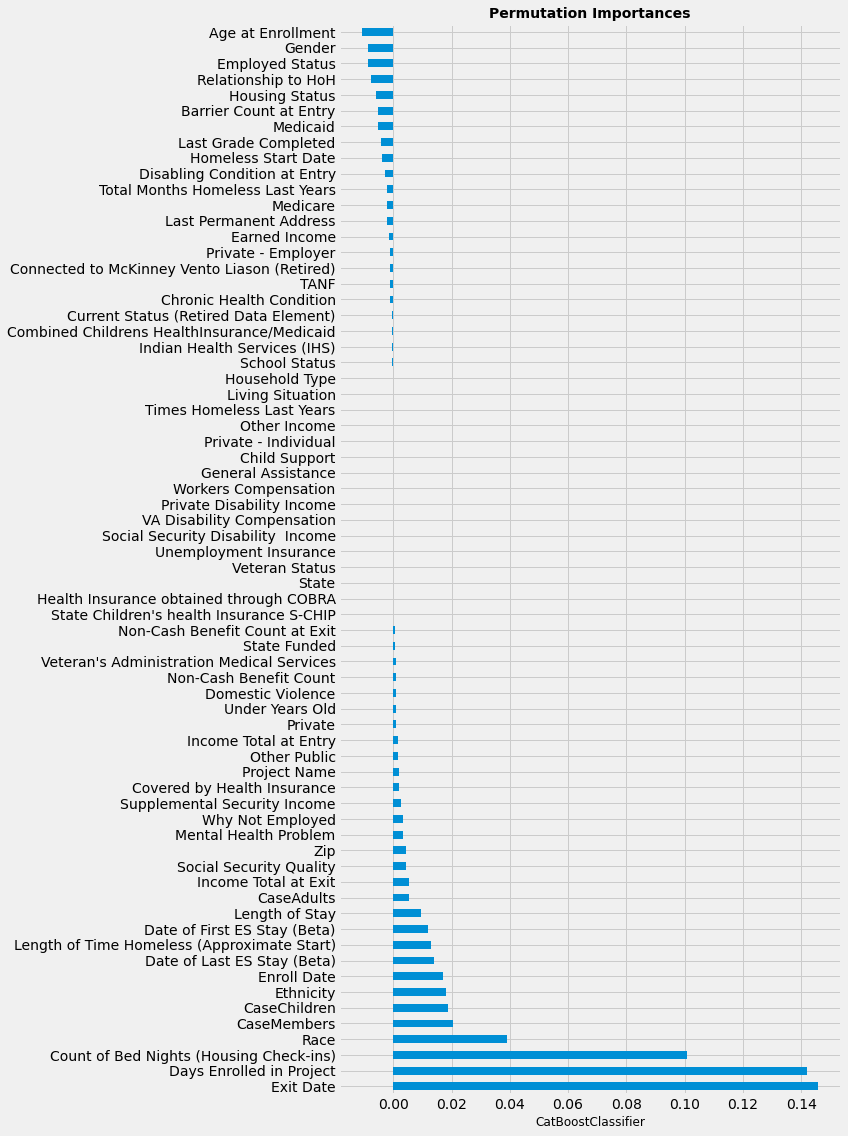

In [70]:
plt.subplots(figsize=(12,16))

cat_perm_imp.importances_mean.plot(kind='barh')

plt.title('Permutation Importances', fontsize=14, fontweight='bold')
plt.xlabel('CatBoostClassifier', fontsize=12)

plt.tight_layout()

#### `XGBoost`

In [71]:
xgb_perm_imp = permutation_importance(xgb_model, X_test, y_test, random_state=0)

In [72]:
data = {'importances_mean' : xgb_perm_imp['importances_mean'],
        'importances_std' : xgb_perm_imp['importances_std']}

xgb_perm_imp = pd.DataFrame(data, index=X_test.columns)
xgb_perm_imp.sort_values('importances_mean', ascending=False, inplace=True)

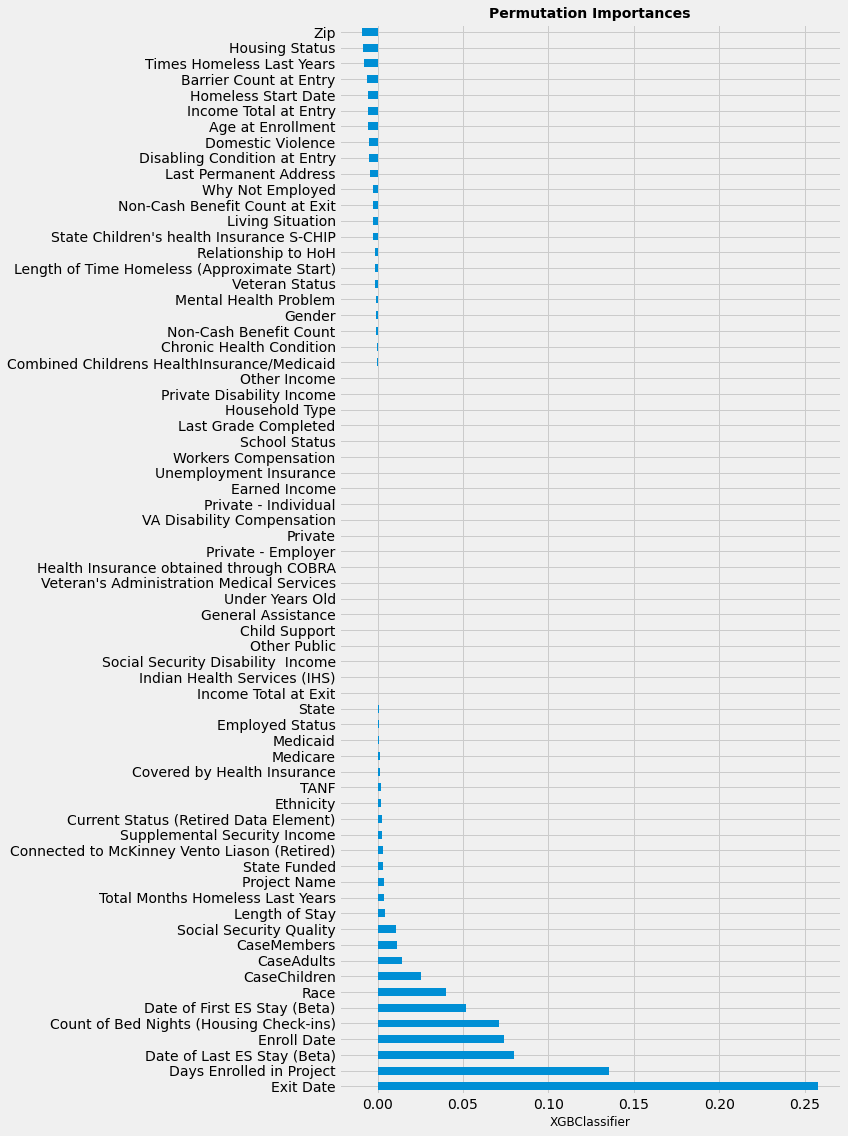

In [73]:
plt.subplots(figsize=(12,16))

xgb_perm_imp.importances_mean.plot(kind='barh')

plt.title('Permutation Importances', fontsize=14, fontweight='bold')
plt.xlabel('XGBClassifier', fontsize=12)

plt.tight_layout()

#### `RandomForest`

In [74]:
forest_perm_imp = permutation_importance(forest_model, X_test, y_test, random_state=0)

In [75]:
data = {'importances_mean' : forest_perm_imp['importances_mean'],
        'importances_std' : forest_perm_imp['importances_std']}

forest_perm_imp = pd.DataFrame(data, index=X_test.columns)
forest_perm_imp.sort_values('importances_mean', ascending=False, inplace=True)

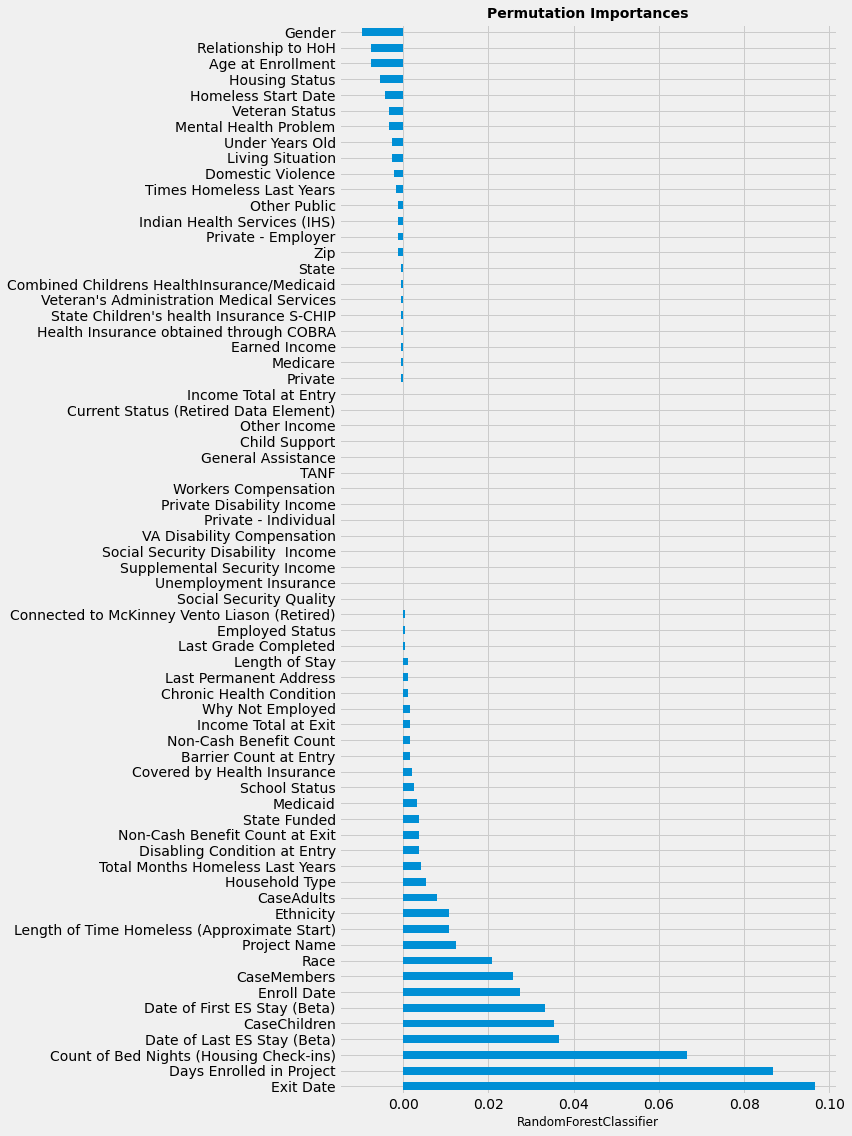

In [76]:
plt.subplots(figsize=(12,16))

forest_perm_imp.importances_mean.plot(kind='barh')

plt.title('Permutation Importances', fontsize=14, fontweight='bold')
plt.xlabel('RandomForestClassifier', fontsize=12)

plt.tight_layout()

## Weights
- Not useful at the moment

#### `CatBoost`

In [119]:
c_model = make_pipeline(
    OrdinalEncoder(),
#     SimpleImputer(), Doesn't work with eli5 weights
    CatBoostClassifier(iterations=5000, random_state=0, verbose=0)
)

c_model.fit(X_train, y_train);

In [120]:
show_weights(c_model, top=25)

Weight,Feature
0.1301,Days Enrolled in Project
0.0981,Count of Bed Nights (Housing Check-ins)
0.0935,Exit Date
0.0565,CaseMembers
0.0518,CaseChildren
0.0492,Date of Last ES Stay (Beta)
0.0473,Enroll Date
0.0456,Race
0.0343,Social Security Quality
0.0340,Date of First ES Stay (Beta)


#### `XGBoost`

In [121]:
x_model = make_pipeline(
    OrdinalEncoder(),
#     SimpleImputer(), Doesn't work with eli5 weights
    XGBClassifier(n_estimators=2500, random_state=0, 
                  booster='gbtree', verbosity=0)
)

x_model.fit(X_train, y_train);

In [122]:
show_weights(x_model, top=25)

Weight,Feature
0.1527,Private
0.0898,Indian Health Services (IHS)
0.0644,Project Name
0.0549,Veteran's Administration Medical Services
0.0420,Other Income
0.0409,State
0.0372,Earned Income
0.0358,Supplemental Security Income
0.0303,Ethnicity
0.0245,Non-Cash Benefit Count


## Shap

## Classification Reports

## Confusion Matrices